## We are intersted in finding out a few things here:
- What are the sites most frequently linked to
    - overall real
    - overall fake
    - real from fake
    - real from real
    - fake from fake
    - fake from real
- Identifying misinformation superlinkers, i.e. sites that link to a lot of misinformational sites
- Identifying "closed" networks of misinformation spread
    - use the avast data to see if there are any patterns here

In [1]:
import pickle
import pandas as pd
import numpy as np

with open('domain_df.pkl', 'rb') as f:
    domain_df = pickle.load(f)
f.close()

with open('connections.pkl', 'rb') as f:
    connections = pickle.load(f)
f.close()

with open('domain_dict.pkl', 'rb') as f:
    domain_dict = pickle.load(f)
f.close()

labels_dict = dict(zip(domain_df.index, domain_df.label))

In [2]:
class link():
    def __init__(self, domain : str, index : int, subindex : int, label : str, domain_dict : dict, labels_dict : dict, connections):
        self.index = index
        self.subindex = subindex
        self.label = label
        self.domain = domain
        self.connections = self.populate_connections(connections, domain_dict, labels_dict)
        self.domain_connections = self.populate_domain_connections(domain_dict, self.connections)

    def populate_connections(self, connections, domain_dict, labels_dict):
        # flip domain dict so it can be accessed by index first
        domain_dict = {v:k for k,v in domain_dict.items()}
        assert self.domain == domain_dict[self.index], 'Error: domain name at domain_dict[self.index] != self.domain'

        cons = {    # Contains lists of domain indices
            'incoming' : None,  # incoming, not including self
            'outgoing' : None,  # outgoing, not including self (true for rest of keys)
            'from_real' : None, # incoming from real
            'from_fake' : None, # incoming from fake
            'to_real' : None,   # outgoing to real
            'to_fake' : None,   # outgoing to fake
        }

        # incoming connections are defined by column
        cons['incoming'] = np.where(connections[:,self.index])[0].tolist()
        if self.index in cons['incoming']:
            cons['incoming'].remove(self.index)

        # outgoing connections are defined by row
        cons['outgoing'] = np.where(connections[self.index,:])[0].tolist()
        if self.index in cons['outgoing']:
            cons['outgoing'].remove(self.index)

        cons['from_real'] = [x for x in cons['incoming'] if labels_dict[x] == 'real']
        cons['from_fake'] = [x for x in cons['incoming'] if labels_dict[x] == 'fake']
        cons['to_real'] = [x for x in cons['outgoing'] if labels_dict[x] == 'real']
        cons['to_fake'] = [x for x in cons['outgoing'] if labels_dict[x] == 'fake']
        return cons

    def populate_domain_connections(self, domain_dict, cons):
        # assert 'self.connections' in locals(), 'Error: self.connections does not exist. run link.populate_connections(connections, domain_dict) first'
        # flip domain dict so it can be accessed by index first
        domain_dict = {v:k for k,v in domain_dict.items()}
        
        domain_connections = {}
        domain_connections['incoming'] = [domain_dict[i] for i in cons['incoming']]
        domain_connections['outgoing'] = [domain_dict[i] for i in cons['outgoing']]
        domain_connections['from_real'] = [domain_dict[i] for i in cons['from_real']]
        domain_connections['from_fake'] = [domain_dict[i] for i in cons['from_fake']]
        domain_connections['to_real'] = [domain_dict[i] for i in cons['to_real']]
        domain_connections['to_fake'] = [domain_dict[i] for i in cons['to_fake']]
        return domain_connections

idx_first_dict = {v:k for k,v in domain_dict.items()}
l = link(domain = idx_first_dict[0], index = 0, subindex=0, label='real', domain_dict=domain_dict, labels_dict=labels_dict, connections=connections)
print(l.__dict__)

{'index': 0, 'subindex': 0, 'label': 'real', 'domain': '.9to5mac.com', 'connections': {'incoming': [166, 595, 694, 837, 882], 'outgoing': [7, 11, 124, 125, 128, 181, 260, 264, 341], 'from_real': [166], 'from_fake': [595, 694, 837, 882], 'to_real': [7, 11, 124, 125, 128, 181, 260, 264, 341], 'to_fake': []}, 'domain_connections': {'incoming': ['.iflscience.com', '.worldtruth.tv', '.humorousmathematics.com', '.drsircus.com', '.thefullertoninformer.com'], 'outgoing': ['.deadline.com', '.theverge.com', '.sfexaminer.com', '.engadget.com', '.pcmag.com', '.variety.com', '.tampabay.com', '.nytimes.com', '.wsj.com'], 'from_real': ['.iflscience.com'], 'from_fake': ['.worldtruth.tv', '.humorousmathematics.com', '.drsircus.com', '.thefullertoninformer.com'], 'to_real': ['.deadline.com', '.theverge.com', '.sfexaminer.com', '.engadget.com', '.pcmag.com', '.variety.com', '.tampabay.com', '.nytimes.com', '.wsj.com'], 'to_fake': []}}


## Let's create a class for the whole dataset

In [3]:
class link_dataset():
    def __init__(self, domain_df, connections, domain_dict):
        self.domain_df = domain_df
        self.connections = connections
        self.domain_dict = domain_dict
        self.labels_dict = dict(zip(domain_df.index, domain_df.label))
        self.links = []   # self.links will be populated with link objects

        for index, row in domain_df.iterrows():
            l = link(domain=row.domain, index=index, subindex=row['index'], label=row.label, domain_dict=domain_dict, labels_dict=self.labels_dict, connections=connections)
            self.links.append(l)
        
        # for l in self.links:
            # l.populate_connections(connections, domain_dict, self.labels_dict)
            # l.populate_domain_connections(domain_dict)

    def get_most_linked_to_sites(self, label=None):
        '''can filter by label, if label is none, will return globally most linked to sites

        ~~~~ ARGUMENTS ~~~~
        - label : str or None
            - 'real' or 'fake'
        
        ~~~~ RETURNS ~~~~
        - link_ranks : DataFrame
            with columns...
            - global_index : int
            - subindex : int
            - domain : str
            - label : str -> "real" or "fake"
            - num_incoming_sites : int
            - incoming_sites_list : list
            - num_incoming_real_sites : int
            - incoming_real_sites_list : list
            - num_incoming_fake_sites : int
            - incoming_fake_sites_list : list
            - num_outgoing_sites : int
            - outgoing_sites_list : list
            - num_outgoing_real_sites : int
            - outgoing_real_sites_list : list
            - num_outgoing_fake_sites : int
            - outgoing_fake_sites_list : list
        '''
        if label:
            assert label == 'real' or label == 'fake', 'Error: label must be "real", "fake", or unspecified if no filtering is required'

        link_ranks = pd.DataFrame(columns = ['global_index', 'subindex', 'domain', 'label', 'num_incoming_sites', 'incoming_sites_list', 'num_incoming_real_sites', 'incoming_real_sites_list', 'num_incoming_fake_sites', 'incoming_fake_sites_list'])
        for l in self.links:
            if label:
                if l.label != label:
                    continue
            link_ranks = link_ranks.append({
                'global_index' : l.index,
                'subindex' : l.subindex,
                'domain' : l.domain,
                'label' : l.label,
                'num_incoming_sites' : len(l.connections['incoming']),
                'incoming_sites_list' : l.domain_connections['incoming'],
                'num_incoming_real_sites' : len(l.connections['from_real']),
                'incoming_real_sites_list' : l.domain_connections['from_real'],
                'num_incoming_fake_sites' : len(l.connections['from_fake']),
                'incoming_fake_sites_list' : l.domain_connections['from_fake'],
                'num_outgoing_sites' : int(len(l.connections['outgoing'])),
                'outgoing_sites_list' : l.domain_connections['outgoing'],
                'num_outgoing_real_sites' : int(len(l.connections['to_real'])),
                'outgoing_real_sites_list' : l.domain_connections['to_real'],
                'num_outgoing_fake_sites' : int(len(l.connections['to_fake'])),
                'outgoing_fake_sites_list' : l.domain_connections['to_fake'],
            }, ignore_index=True)
        link_ranks['num_incoming_sites'] = pd.to_numeric(link_ranks['num_incoming_sites'])
        link_ranks['num_incoming_real_sites'] = pd.to_numeric(link_ranks['num_incoming_real_sites'])
        link_ranks['num_incoming_fake_sites'] = pd.to_numeric(link_ranks['num_incoming_fake_sites'])
        link_ranks['num_outgoing_sites'] = pd.to_numeric(link_ranks['num_outgoing_sites'].astype(int))
        link_ranks['num_outgoing_real_sites'] = pd.to_numeric(link_ranks['num_outgoing_real_sites'].astype(int))
        link_ranks['num_outgoing_fake_sites'] = pd.to_numeric(link_ranks['num_outgoing_fake_sites'].astype(int))
        return link_ranks

link_data = link_dataset(domain_df, connections, domain_dict)
link_ranks = link_data.get_most_linked_to_sites()
link_ranks_real = link_data.get_most_linked_to_sites(label='real')
link_ranks_fake = link_data.get_most_linked_to_sites(label='fake')
link_ranks.head()

,global_index,subindex,domain,label,num_incoming_sites,incoming_sites_list,num_incoming_real_sites,incoming_real_sites_list,num_incoming_fake_sites,incoming_fake_sites_list,num_outgoing_fake_sites,num_outgoing_real_sites,num_outgoing_sites,outgoing_fake_sites_list,outgoing_real_sites_list,outgoing_sites_list
0,0,0,.9to5mac.com,real,5,"[.iflscience.com, .worldtruth.tv, .humorousmat...",1,[.iflscience.com],4,"[.worldtruth.tv, .humorousmathematics.com, .dr...",0,9,9,[],"[.deadline.com, .theverge.com, .sfexaminer.com...","[.deadline.com, .theverge.com, .sfexaminer.com..."
1,1,1,.wfae.org,real,4,"[.marijuanamoment.net, .themarshallproject.org...",3,"[.marijuanamoment.net, .themarshallproject.org...",1,[.covid19up.org],0,6,6,[],"[.gao.gov, .npr.org, .nytimes.com, .seattletim...","[.gao.gov, .npr.org, .nytimes.com, .seattletim..."
2,2,2,.climatefeedback.org,real,1,[.healthfeedback.org],1,[.healthfeedback.org],0,[],0,8,8,[],"[.smithsonianmag.com, .politico.com, .accuweat...","[.smithsonianmag.com, .politico.com, .accuweat..."
3,3,3,.wdbj7.com,real,4,"[.vpap.org, .nbc29.com, .whsv.com, .davidicke....",3,"[.vpap.org, .nbc29.com, .whsv.com]",1,[.davidicke.com],0,2,2,[],"[.nasa.gov, .nbc12.com]","[.nasa.gov, .nbc12.com]"
4,4,4,.keyc.com,real,1,[.thefullertoninformer.com],0,[],1,[.thefullertoninformer.com],0,2,2,[],"[.startribune.com, .wrtv.com]","[.startribune.com, .wrtv.com]"


In [4]:
def summarize_linking(link_ranks):

    incoming = link_ranks.nlargest(5, 'num_incoming_sites')
    incoming_real = link_ranks.nlargest(5, 'num_incoming_real_sites')
    incoming_fake = link_ranks.nlargest(5, 'num_incoming_fake_sites')

    outgoing = link_ranks.nlargest(5, 'num_outgoing_sites')
    outgoing_real = link_ranks.nlargest(5, 'num_outgoing_real_sites')
    outgoing_fake = link_ranks.nlargest(5, 'num_outgoing_fake_sites')

    print('MOST INCOMING LINKS')
    print(incoming[['domain', 'label', 'num_incoming_sites', 'num_incoming_real_sites', 'num_incoming_fake_sites']].to_string(index=False))

    print('\nMOST INCOMING LINKS FROM REAL SITES')
    print(incoming_real[['domain', 'label', 'num_incoming_real_sites']].to_string(index=False))

    print('\nMOST INCOMING LINKS FROM FAKE SITES')
    print(incoming_fake[['domain', 'label', 'num_incoming_fake_sites']].to_string(index=False))

    print('\nMOST OUTGOING LINKS')
    print(outgoing[['domain', 'label', 'num_outgoing_sites', 'num_outgoing_real_sites', 'num_outgoing_fake_sites']].to_string(index=False))

    print('\nMOST OUTGOING LINKS TO REAL SITES')
    print(outgoing_real[['domain', 'label', 'num_outgoing_real_sites']].to_string(index=False))

    print('\nMOST OUTGOING LINKS TO FAKE SITES')
    print(outgoing_fake[['domain', 'label', 'num_outgoing_fake_sites']].to_string(index=False))





print('~~~~~~~~~~ OVERALL ~~~~~~~~~~~')
summarize_linking(link_ranks)
print('\n\n~~~~~~~~~~ ONLY REAL SITES ~~~~~~~~~~~')
summarize_linking(link_ranks_real)
print('\n\n~~~~~~~~~~ ONLY FAKE SITES ~~~~~~~~~~~')
summarize_linking(link_ranks_fake)

~~~~~~~~~~ OVERALL ~~~~~~~~~~~
MOST INCOMING LINKS
           domain label  num_incoming_sites  num_incoming_real_sites  num_incoming_fake_sites
     .nytimes.com  real                 398                      151                      247
         .cdc.gov  real                 385                      217                      168
 .theguardian.com  real                 260                       75                      185
         .npr.org  real                 258                      111                      147
         .wsj.com  real                 248                       88                      160

MOST INCOMING LINKS FROM REAL SITES
        domain label  num_incoming_real_sites
      .cdc.gov  real                      217
  .nytimes.com  real                      151
      .npr.org  real                      111
 .usatoday.com  real                       94
      .wsj.com  real                       88

MOST INCOMING LINKS FROM FAKE SITES
           domain label  num_incomi

## Investigate the predictive power of hyperlinking

<ipython-input-5-47ea161401b5>:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')


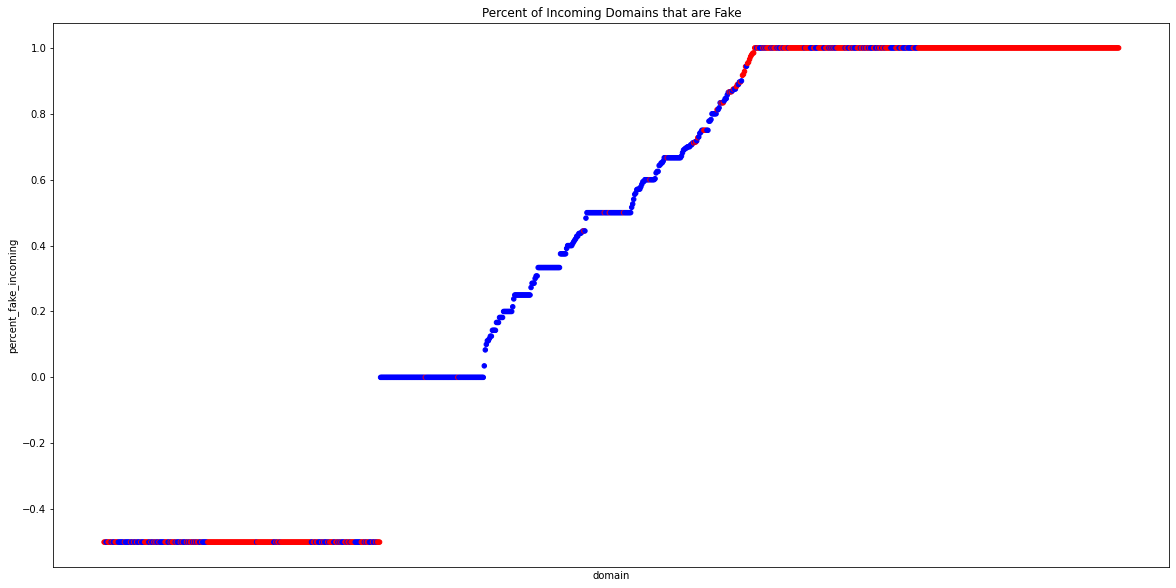

<Figure size 432x288 with 0 Axes>

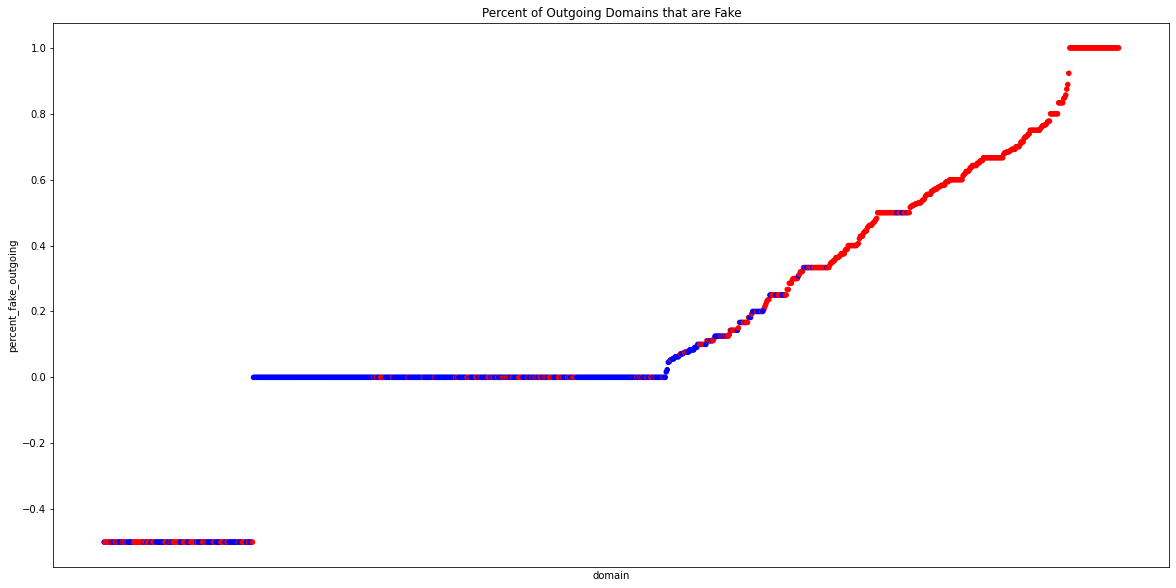

<Figure size 432x288 with 0 Axes>

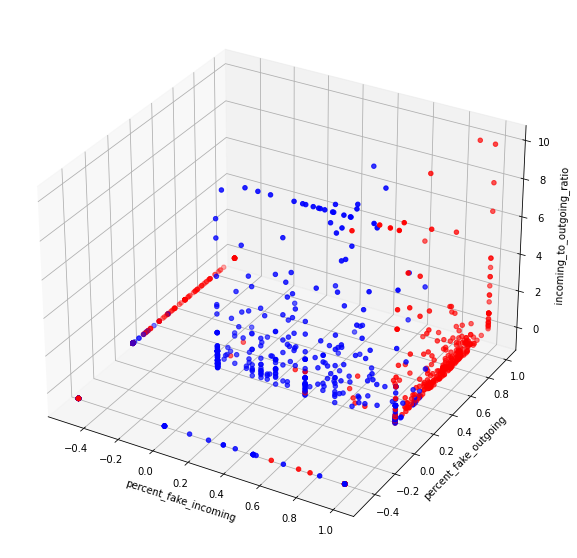

In [5]:
import matplotlib.pyplot as plt


def vectorize_hyperlinking(link_ranks, VISUALIZE=False):
    '''
    creates bar charts of domains displaying
        - % of real vs fake domains outgoing
        - absolute real vs fake domains outgoing
        - $ of real vs fake domains incoming
        - absolute real vs fake domains incoming
        - ratio of incoming links to outgoing links
    '''
    # First, calculate new metrics
    link_ranks['percent_fake_incoming'] = link_ranks.apply(lambda row: row.num_incoming_fake_sites / row.num_incoming_sites if row.num_incoming_sites else -0.5, axis=1)
    link_ranks['percent_fake_outgoing'] = link_ranks.apply(lambda row: row.num_outgoing_fake_sites / row.num_outgoing_sites if row.num_outgoing_sites else -0.5, axis=1)
    link_ranks['incoming_to_outgoing_ratio'] = link_ranks.apply(lambda row: min(row.num_incoming_sites / row.num_outgoing_sites, 10) if row.num_outgoing_sites else -0.5, axis=1)
    link_ranks['color'] = link_ranks.apply(lambda row: 'blue' if row.label == 'real' else 'red', axis=1)
    
    if VISUALIZE:
        # % fake incoming
        link_ranks.sort_values(by='percent_fake_incoming', axis=0, inplace=True)
        link_ranks.plot.scatter(x='domain', y='percent_fake_incoming', color=list(link_ranks['color']), figsize=(20,10))
        plt.xticks([])
        plt.title('Percent of Incoming Domains that are Fake')

        # % fake outgoing
        plt.figure()
        link_ranks.sort_values(by='percent_fake_outgoing', axis=0, inplace=True)
        link_ranks.plot.scatter(x='domain', y='percent_fake_outgoing', color=list(link_ranks['color']), figsize=(20,10))
        plt.xticks([])
        plt.title('Percent of Outgoing Domains that are Fake')

        # ratio of incoming to outgoing links
        plt.figure()
        link_ranks.sort_values(by='incoming_to_outgoing_ratio', axis=0, inplace=True)
        link_ranks.plot.scatter(x='domain', y='incoming_to_outgoing_ratio', color=list(link_ranks['color']), figsize=(20,10))
        plt.xticks([])
        plt.title('Ratio of Incoming to Outgoing Links')

        # 3d plot
        ax = plt.axes(projection='3d')
        ax.scatter3D(link_ranks['percent_fake_incoming'].to_numpy(), 
                     link_ranks['percent_fake_outgoing'].to_numpy(), 
                     link_ranks['incoming_to_outgoing_ratio'].to_numpy(),
                     color=list(link_ranks['color']))
        ax.set_xlabel('percent_fake_incoming')
        ax.set_ylabel('percent_fake_outgoing')
        ax.set_zlabel('incoming_to_outgoing_ratio')

    return link_ranks

link_ranks = vectorize_hyperlinking(link_ranks, VISUALIZE=True)


100%|██████████| 100/100 [00:03<00:00, 32.12it/s]


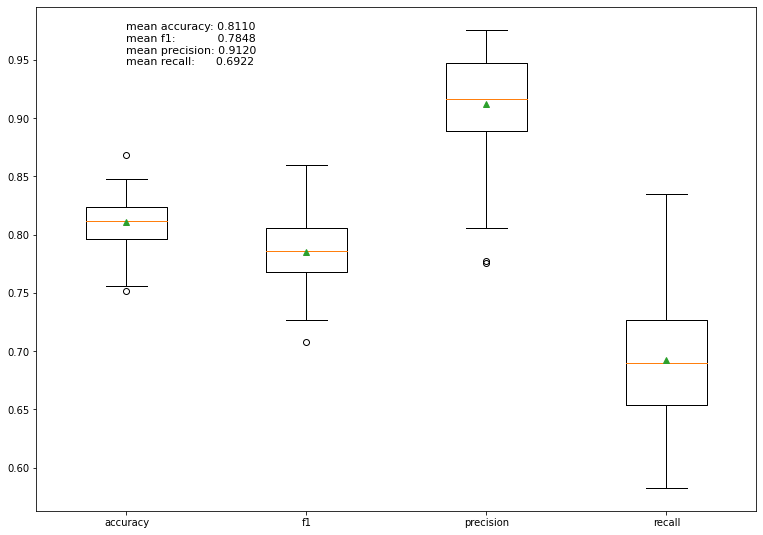

In [6]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

def train_hyperlinking_SVM(link_ranks):

    # vectorized links consists of [percent_fake_incoming, percent_fake_outgoing, incoming_to_outgoing_ratio]
    link_ranks['vectorized_links'] = link_ranks.apply(lambda row: [
        row.percent_fake_incoming, row.percent_fake_outgoing, row.incoming_to_outgoing_ratio
    ], axis=1)
    link_ranks['y'] = link_ranks.apply(lambda row: 1 if row.label == 'fake' else 0, axis=1)
        
    y = link_ranks['y'].to_numpy()
    X = link_ranks['vectorized_links'].tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = svm.SVC()
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test

def evaluate_SVM(model, X_test, y_test):
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return accuracy, f1, precision, recall

def mean_std(series):
    mean = np.mean(series)
    std = np.std(series)
    return mean, std

def populate_results_dataframe(results):
    accuracy_mean, accuracy_std = mean_std(results[0,:])
    f1_mean, f1_std = mean_std(results[1,:])
    precision_mean, precision_std = mean_std(results[2,:])
    recall_mean, recall_std = mean_std(results[3,:])

    results_dict = {
        'metric' : [],
        'lower_bound' : [],
        'mean' : [],
        'upper_bound' : []
    }

    results_dict['metric'].append('accuracy')
    results_dict['lower_bound'].append(accuracy_mean - accuracy_std)
    results_dict['mean'].append(accuracy_mean)
    results_dict['upper_bound'].append(accuracy_mean + accuracy_std)

    results_dict['metric'].append('f1')
    results_dict['lower_bound'].append(f1_mean - f1_std)
    results_dict['mean'].append(f1_mean)
    results_dict['upper_bound'].append(f1_mean + f1_std)

    results_dict['metric'].append('precision')
    results_dict['lower_bound'].append(precision_mean - precision_std)
    results_dict['mean'].append(precision_mean)
    results_dict['upper_bound'].append(precision_mean + precision_std)

    results_dict['metric'].append('recall')
    results_dict['lower_bound'].append(recall_mean - recall_std)
    results_dict['mean'].append(recall_mean)
    results_dict['upper_bound'].append(recall_mean + recall_std)

    df = pd.DataFrame.from_dict(results_dict)
    return df

def boxplot_results(results):
    acc = results[0,:]
    f1 = results[1,:]
    precision = results[2,:]
    recall = results[3,:]

    data = [acc, f1, precision, recall]
    fig = plt.figure(figsize=(10,7))

    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data, showmeans=True)
    plt.xticks([1, 2, 3, 4], ['accuracy', 'f1', 'precision', 'recall'])
    top_y = ax.get_ylim()[1]
    text = 'mean accuracy: {:.4f}\nmean f1:            {:.4f}\nmean precision: {:.4f}\nmean recall:      {:.4f}'.format(
        np.mean(acc), np.mean(f1), np.mean(precision), np.mean(recall)
    )
    plt.text(1, top_y - 0.05*top_y, text, fontsize=11)
    plt.show()

def confidence_interval_SVM(num_iterations, df):
    results = np.zeros(shape=(4, num_iterations))
    for j in tqdm(range(num_iterations)):
        model, _, X_test, _, y_test = train_hyperlinking_SVM(df)
        accuracy, f1, precision, recall = evaluate_SVM(model, X_test, y_test)
        results[0, j] = accuracy
        results[1, j] = f1
        results[2, j] = precision
        results[3, j] = recall
    
    results_df = populate_results_dataframe(results)
    boxplot_results(results)

    return results

results = confidence_interval_SVM(100, link_ranks)
# train_hyperlinking_SVM(link_ranks)

In [7]:
with open('hyperlinking_df.pkl', 'wb') as f:
    pickle.dump(link_ranks, f)
f.close()